In [1]:
'''
this is a notebook containing all the scripts to run the WOS citation analysis formatted in smaller chunks for readability. 
it is not intended to be run as a script, but rather as a notebook.
the scripts in python file formats can be found in the scripts folder.
'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import csv
from collections import Counter

In [2]:
def concatenate_citations(input_dir, output_dir):
    in_path = input_dir + '/*.txt'    # input location of .txt files to process
    for fname in glob.glob(in_path):   # loop through all files in the directory
        with open(fname, 'r') as source_file:   # this will open file with the system's default encoding (typically UTF-8), if needed change to other encoding, specify in the third argument
            newfname = output_dir + fname[len(input_dir):len(fname)-4] + '.csv' # output location of converted files
            with open(newfname, 'w', encoding='utf-8') as dest_file:   # write to new file
                for line in source_file:
                    values = line.split('\t')   # split text by tab characters
                    # values = values[1:45]
                    values = [x.encode('utf-8') for x in values]
                    temp = [str(x,'utf8') for x in values]
                    wr = csv.writer(dest_file, dialect='excel')
                    wr.writerow(temp)
    
    df_list = []
    out_path = output_dir + '/*.csv'
    for fname in glob.glob(out_path):
        df_list.append(pd.read_csv(fname))
    
    print("number of files concatenated: " + str(len(df_list)))

    complete_df = pd.concat(df_list)
    complete_df.to_pickle(output_dir + '/concatenated.pkl')

In [5]:
input_dir = 'files'      # change to desired input directory
output_dir = 'outputs'   # change to desired output directory
concatenate_citations(input_dir, output_dir)

number of files concatenated: 3


In [6]:
df = pd.read_pickle(output_dir + '/concatenated.pkl')
df = df.dropna(subset = ['PY','CR'])  # Get rid of badly imported data
cited_ref = df.CR
orig_art_yr = df.PY

a = cited_ref.size
refs_per = np.zeros(a)  # Citations per article
name = []               # Citation author
year = []               # Cited article year of pub
age = []                # Cited article age wrt published art.
journal = []            # Journal name of cited article

for i, row in enumerate(cited_ref.values):
    auths = cited_ref.values[i]   # Read the cell with all the citations for one article
    parts = auths.split(';')      # Split the citations based on semi-colon
    refs_per[i] = 0;              # Count the number of citations
    
    # Split the citation into parts based on comma to get the year and journal name
    for j in parts:
        if len(j.split(',')) == 3:
            n,y,jou =  j.split(',')
        elif len(j.split(',')) == 4:
            n,y,jou,ver =  j.split(',')
        elif len(j.split(',')) == 5:
            n,y,jou,ver,page =  j.split(',')
        elif len(j.split(',')) == 6:
            n,y,jou,ver,page,doi =  j.split(',')
        y = y.strip()
        if y.isdigit():      # Some citations don't have a year, throw  them away
            name.append(n)
            year.append(y)            
            year = [int(i) for i in year]
            temp = orig_art_yr.values[i] - float(y)
            age.append(temp)         
            journal.append(jou)
            refs_per[i] += 1
        else:
            pass

# Total number of cited references per year, and 
# Average number of cited references per article per year
ref_peryear = []
avgref_peryear = []
xx = np.unique(orig_art_yr)
i = min(orig_art_yr)
for i in xx:
    ii = orig_art_yr == i
    p = refs_per[ii].sum()
    pp = refs_per[ii].mean()
    ref_peryear.append(p)
    avgref_peryear.append(pp)

In [7]:
## Write to file

## the Top Most Cited Journals           
journal = [x.upper() for x in journal]  # Convert all names to uppercase
cc = Counter(journal)
p = cc.most_common()
cols = ['name','count']
pp = pd.DataFrame(p,columns = cols)
pp['name'] = pp['name'].str.upper()  # Convert all names to uppercase
pp = pp.set_index('name')
pp = pp.groupby(pp.index).sum()      # Find duplicate names and add the counts
pp = pp.sort_values(['count'], ascending = [False])   # Sort list by counts
print(pp.index.tolist())
pp.to_csv(output_dir + '/MaxCitedJournals.csv')       # Write to csv file

## the Specific Journal Cited Publication Years
temp1 = pd.DataFrame({'Original article year': orig_art_yr,'references per article': refs_per})
temp1.to_csv(output_dir + '/OriginalArticle_Year_RefCount.csv')
del temp1

## the Cited Journal Age
temp1 = pd.DataFrame({'Cited journal year': year,'Cited journal age': age})
temp1.to_csv(output_dir + '/CitedJournalAge.csv')
del temp1

## the Reference Stats
temp1 = pd.DataFrame({'Year': xx, 'Total refs per year': ref_peryear,'Ave refs per article per year': avgref_peryear}) 	  
temp1.to_csv(output_dir + '/ReferenceStats.csv')
del temp1

[' ACTA BIOMATER', ' BIOMATERIALS', ' MAT SCI ENG C-MATER', ' ADV MATER', ' J BIOMED MATER RES A', ' J CONTROL RELEASE', ' BIOFABRICATION', ' ERGONOMICS', ' PLOS ONE', ' BMC MUSCULOSKEL DIS', ' ACS NANO', ' J MATER CHEM B', ' WORK', ' SCI REP-UK', ' INT J NANOMED', ' MATERIALS', ' J BIOMED MATER RES', ' INT J IND ERGONOM', ' BIOMACROMOLECULES', ' NAT COMMUN', ' NANOMED-NANOTECHNOL', ' INT J BIOL MACROMOL', ' PAIN', ' J BONE MINER RES', ' J PHYS THER SCI', ' ACS APPL MATER INTER', ' ADV HEALTHC MATER', ' J ORTHOP RES', ' POLYMERS-BASEL', ' PROG POLYM SCI', ' EXERC IMMUNOL REV', ' OCCUP ENVIRON MED', ' NAT BIOTECHNOL', ' NATURE', ' POLYM ENG SCI', ' COMPOS PART B-ENG', ' NANOMATER NANOTECHNO', ' FRONT IMMUNOL', ' NANO LETT', ' MUSCLE NERVE', ' PROCEDIA MANUF', ' J TISSUE ENG REGEN M', ' J PHYSIOL-LONDON', ' J ORTHOP TRANSL', ' J MATER SCI-MATER M', ' J NEUROIMMUNOL', ' POROUS TITANIUM PROC', ' J MET MAT MINER', ' CARBOHYD POLYM', ' APPL ERGON', ' ANN PLAS SURG', ' BIOENGINEERING-BASEL', 

In [14]:
def find_citation_year(journals, year):
    # Find the citation year of specified journals after running main script
    d = {}
    for jn in journals:
        indices = [i for i, x in enumerate(journal) if x == jn]
        jyr = [year[i] for i in indices]
        d[jn] = jyr

    pdf = pd.DataFrame.from_dict(d, orient = 'index')
    pdf = pdf.transpose()
    pdf.to_csv('Specific_Journal_Cited_Pub_Years.csv')

In [15]:
journals = ['MAT SCI ENG C-MATER', 'PLOS ONE'] # insert names of journals from MaxCitedJournals list printed frm cell above (follow code pattern to expand as needed)
find_citation_year(journals, year)

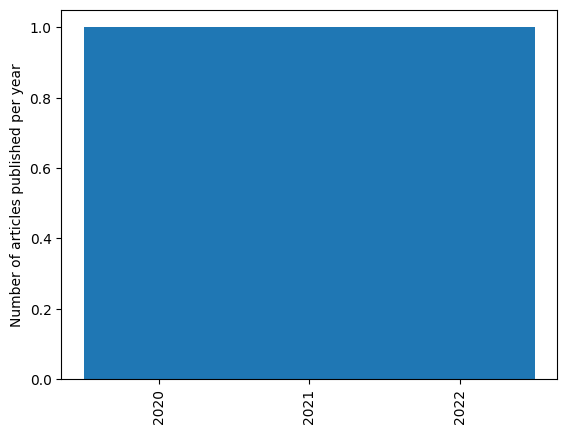

In [6]:
# Number of articles published per year
orig_art_yr = np.array(orig_art_yr,int)
plt.figure()
bins=np.arange(min(orig_art_yr), max(orig_art_yr)+2)
plt.hist(orig_art_yr, bins)
plt.xticks(orig_art_yr+0.5, orig_art_yr, rotation = 90)              
plt.ylabel('Number of articles published per year') 
plt.show()  

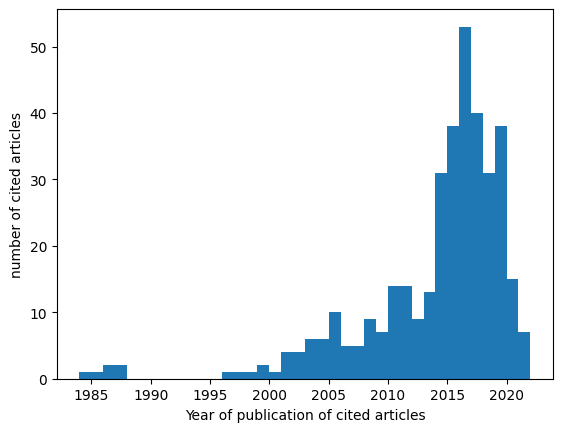

In [7]:
# Year of publication of cited articles
year = np.array(year)
plt.figure()
plt.hist(year, bins = np.arange(min(year), max(year) + 2, 1))
plt.ylabel('number of cited articles')
plt.xlabel('Year of publication of cited articles')  
plt.show()

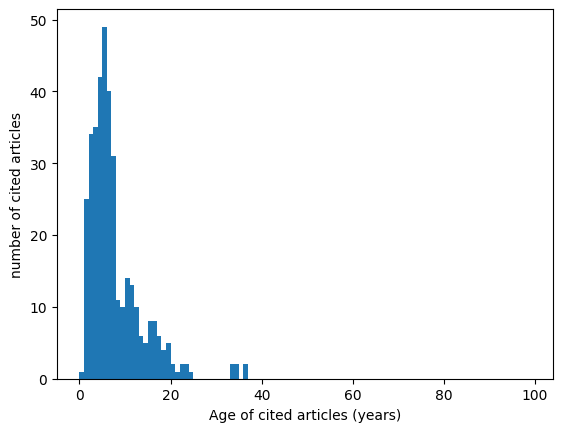

In [8]:
# Age of cited references wrt. published article
age = np.array(age)
plt.figure()
#plt.hist(age, bins=np.arange(min(age), max(age) + 2, 1))
plt.hist(age, bins = np.arange(0, 100, 1))
plt.xlabel('Age of cited articles (years)')  
plt.ylabel('number of cited articles')  
plt.show()

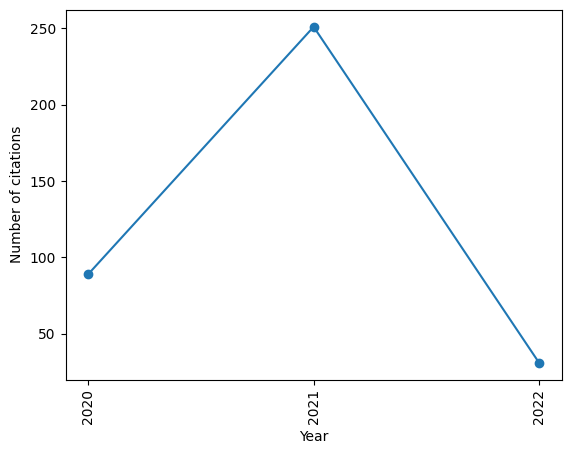

In [9]:
ref_peryear = np.array(ref_peryear)
avgref_peryear = np.array(avgref_peryear)
plt.figure()
plt.plot(xx,ref_peryear,'o-')
plt.xticks(xx, xx, rotation=90)              
plt.ylabel('Number of citations')
plt.xlabel('Year')
plt.show()

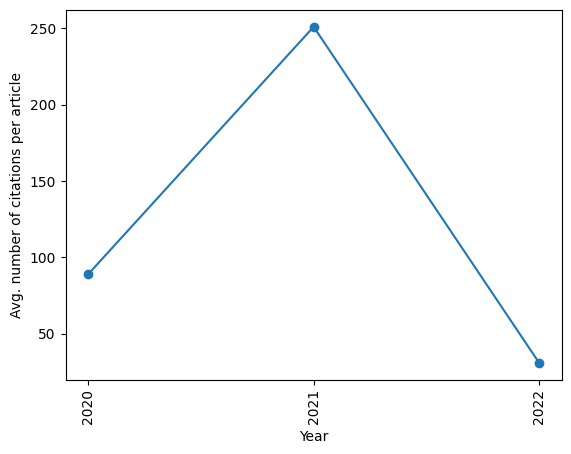

In [10]:
plt.figure()
plt.plot(xx,avgref_peryear,'o-')
plt.xticks(xx, xx, rotation=90)              
plt.ylabel('Avg. number of citations per article')  
plt.xlabel('Year')
plt.show()